In [680]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
sns.set() 

df_orig = pd.read_csv('movie_data_large') 
df = df_orig.copy(deep = True)


**Drop Rows with re-release (all NaN)**

In [681]:
mask = ((df.domestic.isna()) & (df.foreign.isna() & (df.genre.isna())))
df = df.drop(df[mask].index);


**Convert Rank to Float**

In [682]:
df['rank'] = df['rank'].astype(float)


**Drop Rows Where Foreign is NaN and genre is Foreign**

In [683]:
df = df.drop(df[df.foreign.isna()].index)
df = df.drop(df[df.genre == 'Foreign'].index)


**Drop Rows with Unknown Rating, then assign numerical rating**

In [684]:
df = df.drop(df[df.rating == 'Unknown'].index)

def rating_converter(rating):
    rating_conversion = {'Not Yet Rated':1, 'G':2, 'M':3, 'GP':3, 'M/PG':3, 'PG':3, 'PG-13':4, 'R':5, 'X':6, 'NC-17':6, 'Unrated':7}
    num_rating = rating_conversion[rating]
    return (num_rating)

df['rating'] = df.rating.apply(rating_converter)


**To Datetime**

In [685]:
df['close_date'] = pd.to_datetime(df['close_date'])
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_month'] = pd.DatetimeIndex(df['release_date']).month

In [686]:
df.head()

,Unnamed: 0,avg_per_thtr,budget,close_date,days_in_release,director,distributor,domestic,foreign,genre,...,open_wknd,percent_domestic,percent_foreign,prcnt_dom_wknd,rank,rating,release_date,runtime,wdst_rel,release_month
0,Star Wars: The Force Awakens,59982.0,245000000.0,2016-02-06,168.0,J.J. Abrams,Buena Vista,936662225.0,1.131561e+09,Sci-Fi Fantasy,...,247966675.0,45.3,54.7,26.5,1.0,4,2015-12-18,136.0,4134.0,12.0
1,Avengers: Endgame,76601.0,356000000.0,2019-12-09,140.0,Joe Russo,Buena Vista,858373000.0,1.937901e+09,Action / Adventure,...,357115007.0,30.7,69.3,41.6,1.0,4,2019-04-26,181.0,4662.0,4.0
3,Black Panther,50250.0,NaN,2018-09-08,175.0,Ryan Coogler,Buena Vista,700059566.0,6.468536e+08,Action / Adventure,...,202003951.0,52.0,48.0,28.9,1.0,4,2018-02-16,140.0,4084.0,2.0
4,Avengers: Infinity War,57599.0,NaN,2018-09-13,140.0,Joe Russo,Buena Vista,678815482.0,1.369544e+09,Action / Adventure,...,257698183.0,33.1,66.9,38.0,1.0,4,2018-04-27,156.0,4474.0,4.0
6,Jurassic World,48855.0,150000000.0,2015-11-19,NaN,Colin Trevorrow,Universal,652270625.0,1.019443e+09,Action / Adventure,...,208806270.0,39.0,61.0,32.0,1.0,4,2015-12-06,124.0,4291.0,12.0


**Gross Domestic**

In [687]:
df['gross'] = df['domestic'] + df['foreign']

**Inflation Adjustment**

In [689]:
df['xstart_date'] = ('1982-1-1')
df['xstart_date'] = pd.to_datetime(df['xstart_date'])
df['years_since_82'] = pd.DatetimeIndex(df['release_date']).year - pd.DatetimeIndex(df['xstart_date']).year


df['domestic_adjusted'] = df['domestic'] * np.exp((37 - df['years_since_82'].astype(float)) * .025)
df['foreign_adjusted'] = df['foreign'] * np.exp((37 - df['years_since_82'].astype(float)) * .025) 
df['budget_adjusted'] = df['budget'] * np.exp((37 - df['years_since_82'].astype(float)) * .025) 
df['open_wknd_adjusted'] = df['open_wknd'] * np.exp((37 - df['years_since_82'].astype(float)) * .025) 
df['gross_adjusted'] = df['gross'] * np.exp((37 - df['years_since_82'].astype(float)) * .025)

df = df.drop(columns = ['xstart_date'])
df = df.drop(columns = ['years_since_82'])

**Genre Combiner**

In [690]:
df.loc[df[df.genre.str.contains('Comedy')].index,'genre'] = 'Comedy'
df.loc[df[df.genre.str.contains('Action')].index,'genre'] = 'Action'
df.loc[df[df.genre.str.contains('Drama')].index,'genre'] = 'Drama'
df.loc[df[df.genre.str.contains('Fantasy')].index,'genre'] = 'Fantasy'
df.loc[df[df.genre.str.contains('Horror')].index,'genre'] = 'Horror'
df.loc[df[df.genre.str.contains('Sci-Fi')].index,'genre'] = 'Sci-Fi'
df.loc[df[df.genre.str.contains('Family')].index,'genre'] = 'Family'
df.loc[df[df.genre.str.contains('Romantic')].index,'genre'] = 'Romance'
df.loc[df[df.genre.str.contains('Romance')].index,'genre'] = 'Romance'
df.loc[df[df.genre.str.contains('Adventure')].index,'genre'] = 'Adventure'
df.loc[df[df.genre.str.contains('Thriller')].index,'genre'] = 'Thriller'
df.loc[df[df.genre.str.contains('Crime')].index,'genre'] = 'Drama'

In [691]:
df[df.budget.notnull()].shape

(2251, 27)

**Make New DataFrame with Adjusted Values**

In [692]:
df_adjusted = df.copy(deep = True)
df_adjusted = df_adjusted.drop(columns = ['domestic','foreign','budget','director','distributor','open_wknd','avg_per_thtr'])


In [666]:
sns.pairplot(df_adjusted);

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11733e0d0> (for post_execute):


KeyboardInterrupt: 

**Feature Engineering**

In [693]:
df_engin = df_adjusted.copy(deep = True)

In [694]:
df_engin['inv_rank'] = 1/df_engin['rank'] 
df_engin.drop(columns = 'rank', inplace = True)

In [695]:
df_engin['log_budget'] = np.log(df_engin['budget_adjusted'])
df_engin.drop(columns = 'budget_adjusted', inplace = True)

In [696]:
df_engin['log_days_in_rel'] = np.log(df_engin['days_in_release'])
df_engin.drop(columns = 'days_in_release', inplace = True)

In [519]:
df_engin.drop(columns = ['percent_domestic','wdst_rel','domestic_adjusted'], inplace = True)

In [ ]:
sns.pairplot(df_engin)

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1170db488> (for post_execute):


KeyboardInterrupt: 

In [679]:
df_engin.columns

Index(['Unnamed: 0', 'close_date', 'genre', 'numbr_thtr', 'percent_domestic',
       'percent_foreign', 'prcnt_dom_wknd', 'rating', 'release_date',
       'runtime', 'wdst_rel', 'release_month', 'gross', 'domestic_adjusted',
       'foreign_adjusted', 'open_wknd_adjusted', 'inv_rank', 'log_budget',
       'log_days_in_rel'],
      dtype='object')

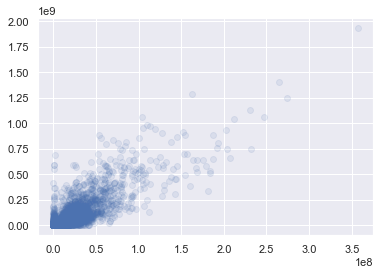

In [520]:
plt.scatter(df_adjusted['open_wknd_adjusted'], df_adjusted['gross_adjusted'],  alpha=.1)

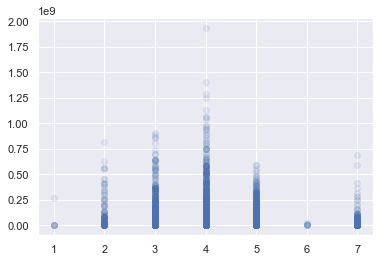

In [521]:
plt.scatter(df_adjusted['rating'], df_adjusted['foreign_adjusted'],  alpha=.1)

In [ ]:
plt.scatter((df_engin['inv_rank']), df_adjusted['gross'],  alpha=.1)

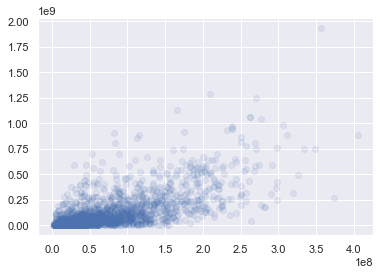

In [523]:
plt.scatter(df_adjusted['budget_adjusted'], df_adjusted['foreign_adjusted'],  alpha=.1)

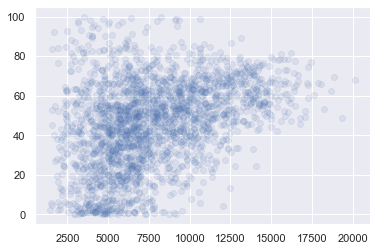

In [524]:
plt.scatter(df_adjusted['budget_adjusted']**.5, df_adjusted['percent_foreign'], alpha = .1)

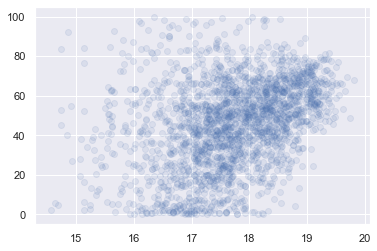

In [528]:
plt.scatter(df_engin['log_budget'], df_engin['percent_foreign'], alpha = .1)

In [529]:
plt.scatter(df_engin['rel_month'], df_adjusted['runtime'], alpha = .1)

KeyError: 'rel_month'

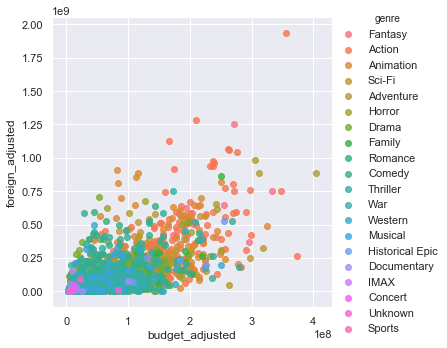

In [672]:
sns.lmplot( x="budget_adjusted", y="foreign_adjusted", data=df_adjusted, fit_reg=False, hue='genre', legend=True)

In [673]:
sns.lmplot( x="release_month", y="gross_adjusted", data=df_adjusted, fit_reg=False, hue='genre', legend=True)

KeyError: "['gross_adjusted'] not in index"

**Lineaer Regressions**

In [609]:
df_noNull = df_adjusted[['budget_adjusted','percent_foreign']].dropna()

In [610]:
X=df_noNull.loc[:,['budget_adjusted']]
y=df_noNull['percent_foreign']

In [611]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [612]:
X_train.shape

(1574, 1)

In [613]:
lr_model1 = LinearRegression(fit_intercept = True)
lr_model1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [614]:
lr_model1.score(X_train, y_train)

0.11934091816999559

In [615]:
lr_model1.coef_[0]

1.2410111878049304e-07

In [616]:
lr_model1.intercept_

36.7899921266535

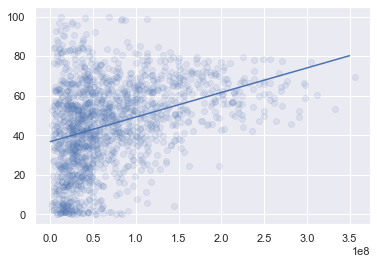

In [632]:
plt.scatter(X_train,y_train,alpha=.1)
vec1 = np.linspace(0,350000000,100000)
plt.plot(vec1, lr_model1.coef_[0]*vec1 + lr_model1.intercept_)

In [142]:
X_1 = df_noNull.loc[:,['budget_adjusted','rating','rank']]

In [132]:
y_1 = df_noNull.loc[:,'percent_foreign']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [134]:
selected_colums = ['open_wknd_adjusted','budget_adjusted','rating']
lr_model1 = LinearRegression()
lr_model1.fit(X_train.loc[:,selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [135]:
lr_model1.coef_

array([1.05828089e-07])

# 